In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [one_column, 2.8]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.00
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |

In [3]:
# Load Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [4]:
stn = 'HWKC1'

var = 'UVGRD:10 m'

# MesoWest Station Info
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']

In [5]:
# Pluck point
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

print lat[x,y], MWlat, 'and',lon[x,y], MWlon

38.73599 38.735086 and -122.83093 -122.837058


In [6]:
if var == 'TMP:2 m':
    ylabel = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    ylabel = '2 m Dew Point (C)'
elif var == 'UVGRD:10 m':
    ylabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    ylabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'REFC:entire':
    ylabel = 'Simulated Composite Reflecivity (dBZ)'
elif var == 'HGT:500':
    ylabel = 'Geopotential Height (m)'

## Get OSG Percentiles for a Point

In [54]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

def seasonal_percentile(p):
    months = {'DJF': [],
              'MAM': [],
              'JJA': [],
              'SON': []}

    for m in months:
        for hour in range(24):
            three_values = []
            if m == 'DJF':
                month_num = [12,1,2]
            elif m == 'MAM':
                month_num = [3,4,5]
            elif m == 'JJA':
                month_num = [6,7,8]
            elif m == 'SON':
                month_num = [9,10,11]

            for mn in month_num:
                FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, mn, 15, hour))
                with h5py.File(DIR+FILE, 'r') as ff:
                    pp = ff['p%02d' % p][x][y]
                    three_values.append(pp)
            months[m].append(np.mean(three_values))
    
    return months

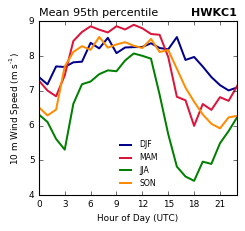

In [65]:
p = 95
months_p95 = seasonal_percentile(p)
colors = ['darkblue', 'crimson', 'green', 'darkorange']

for i, month in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    plt.plot(range(24), months_p95[month],
             color=colors[i],
             label=month)
plt.legend()

plt.xlim([0,23])
plt.xticks(range(0,23,3))

plt.xlabel('Hour of Day (UTC)')
plt.ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

plt.title(stn, loc='right', fontweight='semibold')
plt.title('Mean %02dth percentile' % p, loc='left')

legend = plt.gca().legend(frameon=True, framealpha=.8)
legend.get_frame().set_linewidth(0)

plt.savefig('./figs/%s_mean_%02dth_wind_by_season' % (stn,p))

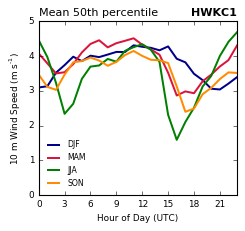

In [64]:
p = 50
months_p95 = seasonal_percentile(p)
colors = ['darkblue', 'crimson', 'green', 'darkorange']

for i, month in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    plt.plot(range(24), months_p95[month],
             color=colors[i],
             label=month)
plt.legend()

plt.xlim([0,23])
plt.xticks(range(0,23,3))
plt.ylim([0,5])

plt.xlabel('Hour of Day (UTC)')
plt.ylabel(r'10 m Wind Speed (m s$\mathregular{^{-1}}$)')

plt.title(stn, loc='right', fontweight='semibold')
plt.title('Mean %02dth percentile' % p, loc='left')

legend = plt.gca().legend(frameon=True, framealpha=.8)
legend.get_frame().set_linewidth(0)

plt.savefig('./figs/%s_mean_%02dth_wind_by_season' % (stn,p))